In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import time
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, WhiteKernel as W
from gn_model import GN_model
font = { 'family' : 'sans-serif',
                'weight' : 'normal',
                'size'   : 14}
matplotlib.rc('font', **font)

In [3]:
data_dir = '/Users/Kate/physical_gp_josh/physics_enhanced_GPs/pch_sweep_data/'
snr = np.genfromtxt(open(str(data_dir) + "pchexpsnrsam100.csv", "r"), delimiter=",", dtype =float)[21:60]
pch = np.genfromtxt(open(str(data_dir) + "pchexppchsam100.csv", "r"), delimiter=",", dtype =float)[21:60]
# snr = np.genfromtxt(open(str(data_dir) + "pchexpsnrsam300.csv", "r"), delimiter=",", dtype =float)
# pch = np.genfromtxt(open(str(data_dir) + "pchexppchsam300.csv", "r"), delimiter=",", dtype =float)

Play around with the amount of data

In [4]:
down_sample_factor = 1
snr = np.array([snr[i] for i in range(len(snr)) if i % down_sample_factor == 0])
pch = np.array([pch[i] for i in range(len(pch)) if i % down_sample_factor == 0])

In [5]:
len(pch)

39

Select a fraction of the data to use for fitting and another fraction for testing.

In [6]:
snr_fit = snr[:-15].reshape(-1,1)
pch_fit = pch[:-15].reshape(-1,1)

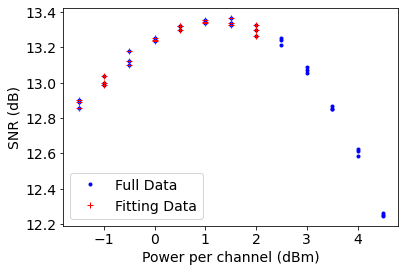

In [7]:
plt.plot(pch, snr, 'b.', label='Full Data')
plt.plot(pch_fit, snr_fit, 'r+', label='Fitting Data')
plt.xlabel("Power per channel (dBm)")
plt.ylabel("SNR (dB)")
plt.legend()
plt.show()

**Inputs**: span length [km], operating central wavelength [nm], number of wavelengths, nonlinearity coefficient[1/(W*km)], dispersion coefficient[ps^2/km], loss [db/km], symbol rate [GBd], channel bandwidth [GHz], grid spacing [GHz], EDFA noise figure [dB], number of spans, TRx back to back [dB]

In [8]:
phys_model = GN_model(100, 1550, 1, 1.1, 18, 0.18, 35, 40.2, 50, 4, 10, 16.5)

According to Javier, the measurements of Pch may not be reliable and we may need to shift them in order to obtain agreement with the GN model. We do this by calculating the input power per channel that corresponds to peak SNR in the GN model and shifting the peak of measured data to line up with this prediction.

In [9]:
pch_gn = np.linspace(-5, 5, 100)
pch_fit_shifted = pch_fit - (1.25 - pch_gn[np.argmax(phys_model.predict_snr(pch_gn))])
pch_shifted = pch - (1.25 - pch_gn[np.argmax(phys_model.predict_snr(pch_gn))])
snr_phys = phys_model.predict_snr(pch_fit_shifted).reshape(-1,1)

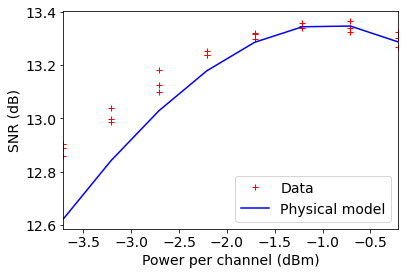

In [10]:
plt.plot(pch_fit_shifted, snr_fit, 'r+', label='Data')
plt.plot(pch_fit_shifted, snr_phys, 'b-', label='Physical model')
plt.xlim([pch_fit_shifted[0], pch_fit_shifted[-1]])
plt.xlabel("Power per channel (dBm)")
plt.ylabel("SNR (dB)")
plt.legend()
#plt.savefig('powershifted_gn_comparison.pdf', dpi=200,bbox_inches='tight')
plt.show()

Need to think about how many datapoints I will use for the physical model - ideally dont want to use the same number of datapoints as the data as then we dont get the benefit for a low number of points... 

In [10]:
num_points_phys = 25
#pch_test = np.linspace(pch_fit_shifted[0], pch_fit_shifted[-1], 50).reshape(-1,1) 
pch_test = np.linspace(pch_shifted[0], pch_shifted[-1], num_points_phys).reshape(-1,1) 
#snr_phys_test = phys_model.predict_snr(pch_test).reshape(-1,1)
snr_phys_test = (phys_model.predict_snr(pch_test).reshape(len(pch_test),) + np.random.normal(0, 0.03, len(pch_test))).reshape(-1,1)

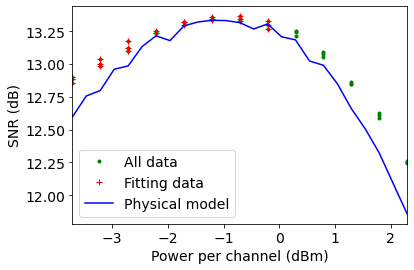

In [11]:
#plt.plot(pch_shifted[-9:], snr[-9:], 'g.', label='All data')
plt.plot(pch_shifted, snr, 'g.', label='All data')
plt.plot(pch_fit_shifted, snr_fit, 'r+', label='Fitting data')
plt.plot(pch_test, snr_phys_test, 'b-', label='Physical model')
plt.xlim([pch_shifted[0], pch_shifted[-1]])
plt.xlabel("Power per channel (dBm)")
plt.ylabel("SNR (dB)")
plt.legend()
#plt.savefig('powershifted_gn_comparison.pdf', dpi=200,bbox_inches='tight')
plt.show()

In [12]:
pch_fit_shifted = pch_fit_shifted.reshape(-1, 1)  # needed for SK learn input
#pch_predict = np.linspace(pch_shifted[0], pch_shifted[-1] + 1.0)
pch_shifted = pch_shifted.reshape(-1,1)
kernel_sk = C(1, (1e-5, 1e5)) * RBF(1, (1e-5, 1e5)) +  W(1, (1e-5,1e5))
gpr_phys = GaussianProcessRegressor(kernel=kernel_sk, n_restarts_optimizer = 20, normalize_y=True)
gpr_phys.fit_phys(pch_fit_shifted, pch_test, snr_fit, snr_phys_test)
#print("Optimised kernel: %s" % gpr.kernel_)
mu_sk_phys, std_sk_phys = gpr_phys.predict(pch_shifted, return_std=True)
std_sk_phys = np.reshape(std_sk_phys,(np.size(std_sk_phys), 1)) 
theta_phys = gpr_phys.kernel_.theta
lml_phys = gpr_phys.log_marginal_likelihood()
mu_sk_p2_phys = mu_sk_phys + 2*std_sk_phys 
mu_sk_n2_phys = mu_sk_phys - 2*std_sk_phys 

ValueError: Found input variables with inconsistent numbers of samples: [24, 25]

In [14]:
pch_fit_shifted = pch_fit_shifted.reshape(-1, 1)  # needed for SK learn input
pch_shifted = pch_shifted.reshape(-1, 1)  # needed for SK learn input
kernel_sk =   C(1, (1e-5, 1e5)) * RBF(1, (1e-5, 1e5)) + W(1, (1e-5,1e5))
gpr = GaussianProcessRegressor(kernel=kernel_sk, n_restarts_optimizer = 20, normalize_y=True)
gpr.fit(pch_fit_shifted, snr_fit)
#print("Optimised kernel: %s" % gpr.kernel_)
mu_sk, std_sk = gpr.predict(pch_shifted, return_std=True)
std_sk = np.reshape(std_sk,(np.size(std_sk), 1)) 
theta = gpr.kernel_.theta
lml = gpr.log_marginal_likelihood()
mu_sk_p2 = mu_sk + 2*std_sk 
mu_sk_n2 = mu_sk - 2*std_sk 

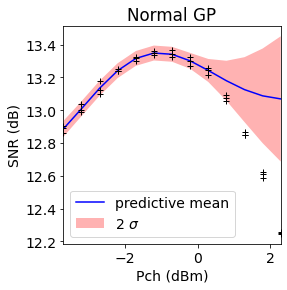

In [15]:
f, ax = plt.subplots()
ax.plot(pch_shifted, mu_sk, 'b-', label = 'predictive mean')
ax.plot(pch_shifted, snr,'k+')
#ax.plot(pch_shifted, snr_phys, 'g--', label = 'GN model')
ax.fill(np.concatenate([pch_shifted, pch_shifted[::-1]]),
            np.concatenate([mu_sk_p2,
                            (mu_sk_n2)[::-1]]),
            alpha=0.3, fc='r', ec='None', label='2 $\sigma$')
plt.xlim(pch_shifted[0], pch_shifted[-1])
plt.xlabel("Pch (dBm)")
plt.ylabel("SNR (dB)")
plt.title("Normal GP")
plt.legend()
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
f.patch.set_facecolor('w')
plt.savefig('normal_GP.pdf', dpi=200,bbox_inches='tight')
plt.show()

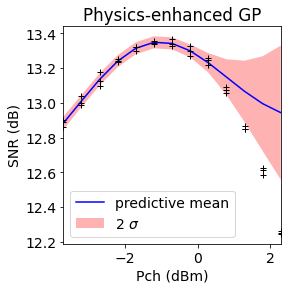

In [16]:
f, ax = plt.subplots()
ax.plot(pch_shifted, mu_sk_phys, 'b-', label = 'predictive mean')
ax.plot(pch_shifted, snr,'k+')
#ax.plot(pch_shifted, snr_phys, 'g--', label = 'GN model')
ax.fill(np.concatenate([pch_shifted, pch_shifted[::-1]]),
            np.concatenate([mu_sk_p2_phys,
                            (mu_sk_n2_phys)[::-1]]),
            alpha=0.3, fc='r', ec='None', label='2 $\sigma$')
plt.xlim(pch_shifted[0], pch_shifted[-1])
plt.xlabel("Pch (dBm)")
plt.ylabel("SNR (dB)")
plt.title("Physics-enhanced GP")
plt.legend()
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
f.patch.set_facecolor('w')
plt.savefig('phys_enhanced_GP.pdf', dpi=200,bbox_inches='tight')
plt.show()

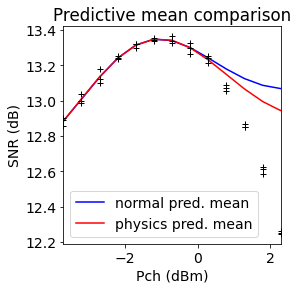

In [17]:
f, ax = plt.subplots()
ax.plot(pch_shifted, mu_sk, 'b-', label = 'normal pred. mean')
ax.plot(pch_shifted, mu_sk_phys, 'r-', label = 'physics pred. mean')
ax.plot(pch_shifted, snr,'k+')
#ax.plot(pch_shifted, snr_phys, 'g--', label = 'GN model')
plt.xlim(pch_shifted[0], pch_shifted[-1])
plt.xlabel("Pch (dBm)")
plt.ylabel("SNR (dB)")
plt.title("Predictive mean comparison")
plt.legend()
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
#plt.savefig('.pdf', dpi=200,bbox_inches='tight')
plt.show()

This is not entirely unexpected - we have used a physical model to help bias the kernel parameters towards a model that makes more sense beyond the range of the dataset. We gave the model data only from the **linear regime** and then tried to predict in the **non-linear regime**. In the case where we give the model an idea of the physics of the system, it performs much better in this regime (but still not perfectly...). 
This is a promising step in the right direction. 

In [24]:
max(std_sk)

array([0.05612564])

In [25]:
max(std_sk_phys)

array([0.03675556])

Relative change in the predictive std (%):

In [21]:
100*(max(std_sk_phys) - max(std_sk))/max(std_sk)

array([-34.07244287])

Initial results - see a drop in the predictive std of the model, likely because more datapoints used in fitting. 

RMSD of the predictive mean of the model with and without physical models:

In [22]:
np.mean(((mu_sk - mu_sk_phys)**2)**0.5)

0.015478679643220762

Mean relative difference (%):

In [23]:
np.mean(100*(mu_sk - mu_sk_phys)/mu_sk)

0.11125134626132141

In [24]:
np.exp(theta)  # mu, l, sigma: kernel specified as mu**2 * RBF(l**2) + I sigma**2 

array([3.24476498e+01, 3.75289657e+00, 2.25393156e-02])

In [25]:
np.exp(theta_phys)

array([9.38685586e+01, 4.99880434e+00, 7.98639774e-03])

Some observations:
* Difference in the noise level: reduced in the physical model case, this is reflected in the predictive std of the model
* The predictive mean of the models when the physical model information is given over the same range is the same to within a small amount but the mu and l parameters of the RBF kernel are different - a different local minimum has been found as the LML function used in optimisation was different (biased by the physical model) 
* Should note that the physics-enhanced model appears to be over-confident, as more points than you would expect lie outside of the 2 sigma confidence region (we expect ~3.5) as 2 sigma is roughly 95%. 